# Custom YOLOv5 Train and Deploy on Amazon SageMaker

### Create and deploy your model 

**Steps:**

0. Initial configuration.
1. Pre-process Pascal-VOC data to YOLOv5 format with SM Processing Jobs.
2. Train the custom YOLOv5 model with SageMaker Training Jobs.
3. Deploy the model with SageMaker Endpoints

## 0. Initial Configuration

Let's begin by loading all the necessary libraries and repos to execute the notebook

In [127]:
!pip install -qU sagemaker
!pip install opencv-python-headless
import json, os, uuid, time, sagemaker
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

sm_session = sagemaker.Session()
role = get_execution_role()


In [ ]:
!mkdir scripts
!git clone -q https://github.com/ultralytics/yolov5 scripts
!wget -q https://github.com/ultralytics/yolov5/releases/download/v6.2/yolov5s.pt -P scripts

## 1. Pre-process Pascal-VOC data to YOLOv5 format with SM Processing Jobs.

Before we train our model on YOLOv5 we need to convert data from Pascal VOC format to YOLOv5 expected format.

The expected input of data follows the following structure:
    
    - images
        - *.jpeg
    - labels
        - *.xml

Complete input data and classes data

In [ ]:
raw_data_uri = "" # Provide your S3 labeled data folder that contains images and labels
objects_classes =["pen","mm"] # Provide the names of your classes following your labeling order

Here we will create the processing entrypoint python file. 

In [ ]:
%%writefile preprocess.py

import os
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

input_images = "/opt/ml/processing/input/images"
input_labels = "/opt/ml/processing/input/labels"
output_path = "/opt/ml/processing/output/training_data"
output_images = "{}/images".format(output_path)
output_labels = "{}/labels".format(output_path)
output_images_train = "{}/images/train".format(output_path)
output_images_val = "{}/images/val".format(output_path)
output_labels_train = "{}/labels/train".format(output_path)
output_labels_val = "{}/labels/val".format(output_path)


os.makedirs(output_images_train, exist_ok=True)
os.makedirs(output_images_val, exist_ok=True)
os.makedirs(output_labels_train, exist_ok=True)
os.makedirs(output_labels_val, exist_ok=True)

files = os.listdir(input_images)
classes = ["pen","mm"]

train_data, validation_data = train_test_split(files, test_size=0.1)

def convert_box(size, box):
      dw, dh = 1. / size[0], 1. / size[1]
      x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
      return x * dw, y * dh, w * dw, h * dh
    
def convert_label(filename,cat):
        in_file = open("{}/{}.xml".format(input_labels,filename))
        out_file = open("{}/{}/{}.txt".format(output_labels,cat,filename), 'w')

        tree = ET.parse(in_file)
        root = tree.getroot()
        size = root.find('size')
        file = root.find('filename').text
        path = root.find('path').text
        folder = root.find('folder').text
        shutil.copyfile("{}/{}.jpeg".format(input_images,filename),"{}/{}/{}.jpeg".format(output_images,cat,filename))
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        names = classes  # names list
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls in names and int(obj.find('difficult').text) != 1:
                xmlbox = obj.find('bndbox')
                bb = convert_box((w, h), [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')])
                cls_id = names.index(cls)  # class id
                #print(" ".join([str(a) for a in (cls_id, *bb)]) + '\n')
                out_file.write(" ".join([str(a) for a in (cls_id, *bb)]) + '\n')
        out_file.close()
        in_file.close()
        
for image in train_data:
    img_name = image.split(".jpeg")[0]
    convert_label(img_name,"train")

for image in validation_data:
    img_name = image.split(".jpeg")[0]
    convert_label(img_name,"val")
    
print("Finished processing")

Now we create the SKLearnProcessor and run it. 

In [ ]:
sklearn_processor = SKLearnProcessor(
    framework_version="1.0-1",
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="p2y5-job",
    role=role,
    sagemaker_session=sm_session,
)

In [ ]:
sklearn_processor.run(
    inputs=[
        ProcessingInput(source=raw_data_uri, destination="/opt/ml/processing/input/")
    ],
    outputs=[
        ProcessingOutput(output_name="training_data", source="/opt/ml/processing/output/training_data")
    ],
    code="preprocess.py",
)

Once the processing job has finished, we will retrieve the training data location

In [ ]:
training_data_input = sklearn_processor.jobs[-1].describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
training_data_input

Here we create the data format file YOLOv5 needs to retrieve the path of our dataset.

In [ ]:
%%writefile scripts/data/Custom-VOC.yaml

path: /opt/ml/input/data/train 
train: images/train
val: images/val
names:
  0: pen
  1: mm

# Download script/URL (optional) ---------------------------------------------------------------------------------------
download: |

## 2. Train the custom YOLOv5 model with SageMaker Training Jobs.

In [114]:
training_name = "p2y-train"
job_name = '{}-{}'.format(training_name,str(uuid.uuid4()))
print(job_name)

p2y-train-3cdee84d-6090-45d5-a55e-dad92bf4ec16


In [115]:
hyperparameters={
    "workers":"8",
    "device": "0",
    "batch-size": "8",
    "epochs": "50",
    "data": "Custom-VOC.yaml",
    "weights": "yolov5s.pt",
    "project": "/opt/ml/model"
}

estimator = PyTorch(
    framework_version='1.11.0',
    py_version='py38',
    entry_point='train.py',
    source_dir='scripts',
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type='ml.g5.2xlarge',
    role=role,
    disable_profiler=True, 
    debugger_hook_config=False
)

In [116]:
estimator.fit({'train': training_data_input}, job_name=job_name)

2022-10-19 15:27:19 Starting - Starting the training job...
2022-10-19 15:27:35 Starting - Preparing the instances for training......
2022-10-19 15:28:49 Downloading - Downloading input data...
2022-10-19 15:29:09 Training - Downloading the training image........................
2022-10-19 15:33:05 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-19 15:33:07,950 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-19 15:33:07,972 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-19 15:33:07,978 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-19 15:33:08,867 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━

In [117]:
model_name = "M-{}".format(job_name)
model_data = 's3://{}/{}/output/model.tar.gz'.format(sm_session.default_bucket(), job_name)
print(model_data)

s3://sagemaker-eu-west-1-238023316787/p2y-train-3cdee84d-6090-45d5-a55e-dad92bf4ec16/output/model.tar.gz


## 3. Deploy your model to a SM Endpoint.

In [118]:
%%writefile scripts/detect.py
import argparse
import os
import platform
import sys
import torch
import json

def model_fn(model_dir):
    model = torch.hub.load("ultralytics/yolov5", "custom", path="/opt/ml/model/exp/weights/best.pt", force_reload=True)
    print("Model Loaded")
    return model

def input_fn(serialized_input_data, content_type):
    if content_type == 'application/json':
        print(f'input_fn - serialized_input_data: {serialized_input_data}')
        input_data = json.loads(serialized_input_data)
        return input_data
    else:
        raise Exception('Requested unsupported ContentType in Accept: ' + content_type)
        return

def predict_fn(input_data, model):
    print(f'predict_fn - input_data: {input_data}')
    imgs = [input_data]
    results = model(imgs)
    print(results)
    df = results.pandas().xyxy[0]
    return(df.to_json(orient="split"))

Overwriting scripts/detect.py


In [119]:
model = PyTorchModel(
    entry_point='detect.py',
    source_dir='scripts',
    model_data=model_data,
    framework_version='1.11.0',
    py_version='py38',
    role=role,
    name=model_name
)

In [120]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.c5.large')
predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

------!

### Display predictions

In [121]:
predictions = predictor.predict("https://i.ibb.co/xFRgz75/test1.jpg")

In [122]:
pr = json.loads(predictions)
df = pd.DataFrame(data=pr["data"], index = pr["index"], columns = pr["columns"])
print(df)

         xmin        ymin        xmax        ymax  confidence  class name
0  198.228912  237.518646  463.509674  333.315948    0.486473      0  pen


In [123]:
def draw_label (image, box, conf, label):
    bbox = np.array(box).astype(np.int32)
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), [255,0,0], 2, cv2.LINE_AA)
    cv2.putText(image, "{}:{}".format(label,str(conf)[0:4]), (bbox[0], bbox[1] - 10),  0, 1e-3 * imgHeight, [255,0,0], 2)
    
def resize_bb(old, new, min_b, max_b):
    old = np.array(old)
    new = np.array(new)
    min_b = np.array(min_b)
    max_b = np.array(max_b)
    min_xy = min_b/(old/new)
    max_xy = max_b/(old/new)
    return [int(min_xy[0]),int(min_xy[1]),int(max_xy[0]),int(max_xy[1])]

def plot_image(img):
    dpi = 80
    figsize = imgWidth / float(dpi), imgHeight / float(dpi)    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [128]:
img = cv2.imread("test.jpg")
imgHeight,imgWidth,_ = img.shape

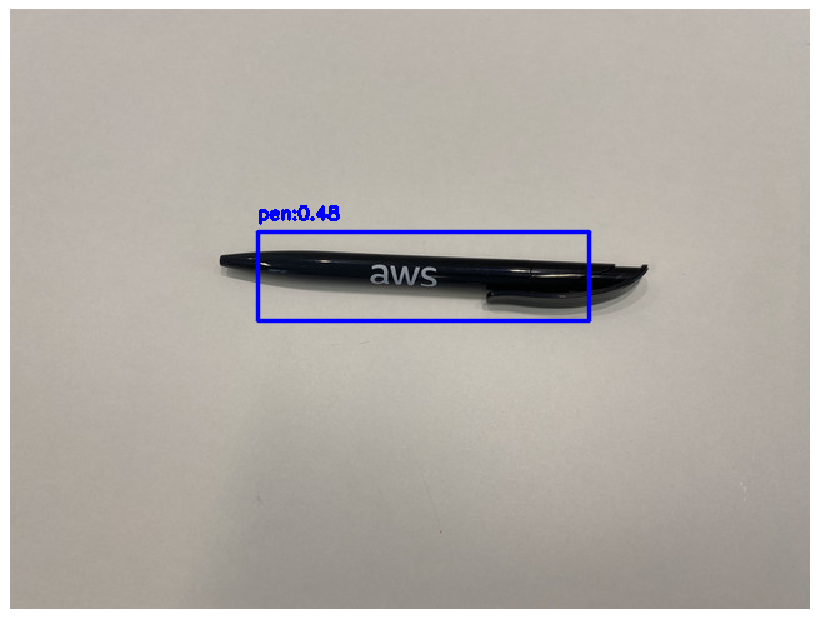

In [130]:
for index, row in df.iterrows():
    if row['confidence'] > 0.4:
        new_boxes = resize_bb([640,640],[imgWidth,imgHeight],[row['xmin'],row['ymin']],[row['xmax'],row['ymax']])
        draw_label(img, new_boxes,row["confidence"],row['name'])

plot_image(img)